In [570]:
%matplotlib inline
%reset
from IPython.display import display

import numpy as np
import matplotlib.pyplot as plt
import scipy

import SchemDraw as schem # to draw schematics (install using 'pip install SchemDraw')
import SchemDraw.elements as e

import skrf as rf # scikit-rf (install using 'conda -c scikit-rf scikit-rf')

import sympy # sympy (install using 'conda -c sympy sympy')
from sympy import I # imaginary symbol

rf.stylely() # enable scikit-rf plot styles
sympy.init_printing(use_latex='mathjax') # print sympy equations in MathJAX (for Jupyter)
# Useful links:
# http://www.qsl.net/in3otd/electronics/Z_fitting/impedance_fitting.html

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [571]:
# sympy fun! - just for reference
# x = sympy.symbols('x')
# display(sympy.diff(sympy.sin(x) * sympy.exp(x), x))
# display(sympy.integrate(sympy.sin(x**2), (x, -sympy.oo, sympy.oo)))
# sympy.subs - expr.subs([(sym1, val1), (sym2, val2)]) WARNING: not very performant use lambdify instead with numpy
# sympy.Eq (sets 2 expressions equal symbolically (dont use ==))
# sympy.simplify (to check symbolic equality: simplify(expr1 - expr2))
# sympy.equals (test expression equality with random numerical evaluation) expr1.equals(expr2)
# sympy.Integer(x) - creates SymPy integer
# sympy.Rational(x,y) - creates symbolic fraction
# sympy.evalf - expr.evalf() - evaluates numerical expression into floating point number
# sympy.lambdify((sym1, sym2, sym3), expr, "numpy") - returns a function

In [754]:
# helper functions
def ll(a, b): # return a and b in parallel (symbolically)
    return (a * b) / (a + b)
def mag2db(mag):
    return np.multiply(20.0, np.log10(mag))
def db2mag(db):
    return np.power(10, np.divide(db, 20.0))
def rad2deg(rad):
    return np.multiply(np.divide(rad, (2*np.pi)), 360.0)
def deg2rad(deg):
    return np.multiply(np.divide(deg, 360.0), 2*np.pi)
def nH(henries):
    return str('%.3f' % (henries/1e-9) + ' nH')
def pF(farads):
    return str('%.3f' % (farads/1e-12) + ' pF')
def fF(farads):
    return str('%.3f' % (farads/1e-15) + ' fF')
def mOhm(ohms):
    return str('$' + '%.3f' % (ohms/1e-3) + ' m\Omega$')
def Ohm(ohms):
    return str('$' + '%.3f' % (ohms) + ' \Omega$')
def Z2S(Z, Z0=50.0):
    delta = (Z[0][0] + Z0) * (Z[1][1] + Z0) - Z[0][1]*Z[1][0]
    S11 = ((Z[0][0] - Z0) * (Z[1][1] + Z0) - Z[0][1]*Z[1][0]) / delta
    S12 = (2 * Z0 * Z[0][1]) / delta
    S21 = (2 * Z0 * Z[1][0]) / delta
    S22 = ((Z[0][0] + Z0) * (Z[1][1] - Z0) - Z[0][1]*Z[1][0]) / delta
    return [[S11, S12], [S21, S22]]
def lambdify_matrix(fn_arg_symbols, matrix):
    return [list(map(lambda x: sympy.lambdify(fn_arg_symbols, x, "numpy"), z)) for z in matrix]

In [638]:
# Collected data
sma_dummy_short_data = rf.Network('data/sma_dummy_short.S2P')
small_tline_data = rf.Network('original_data/thru_0p7mm.s2p')['0.4-2Ghz']
open_data = rf.Network('original_data/OPEN.S2P')['0.1-1.4Ghz']
shunt_short_data = rf.Network('original_data/SHUNT_SHORT.S2P')['0.1-1.8Ghz']
zero_ohm_series_data = rf.Network('original_data/ZERO_OHM_SERIES.S2P')['0.1-1.2Ghz']
zero_ohm_shunt_data = rf.Network('original_data/ZERO_OHM_SHUNT.S2P')['0.1-1.8Ghz']

In [755]:
def sma_dummy_short_model():
    R, L, C, w = sympy.symbols('R L C \omega', real=True)
    L_j = I * w * L
    C_j = (I * w * C)**-1
    Z11 = sympy.simplify(ll(L_j + R, C_j))
    Z11_function = sympy.lambdify((w, C, L, R), Z11, "numpy")
    print("SMA Dummy Short Z11 Symbolic Model:")
    display(Z11)
    return Z11_function

def sma_dummy_short_schematic(C='$C_{sma}$', R='$R_{short+sma}$', L='$L_{short+sma}$'):
    print("SMA Dummy Short Schematic Model:")
    d = schem.Drawing(unit=1.5)
    C_sma = d.add(e.CAP, d='up', label=C)
    hori_line = d.add(e.LINE, d='right', l=2)
    d.add(e.RES, d='down', botlabel=R)
    L_short = d.add(e.INDUCTOR, d='down', botlabel=L)
    d.add(e.LINE, d='right', l=1)
    d.add(e.DOT_OPEN)
    short_line1 = d.add(e.LINE, d='right', l=4)
    d.add(e.LINE, d='right', xy=hori_line.end, l=1)
    d.add(e.DOT_OPEN)
    short_line2 = d.add(e.LINE, d='right', l=4)
    d.add(e.LINE, d='left', xy=C_sma.end, l=1)
    d.add(e.DOT_OPEN)
    d.add(e.LINE, xy=C_sma.start, to=L_short.end)
    d.add(e.LINE, d='left', xy=C_sma.start, l=1)
    d.add(e.DOT_OPEN)
    d.add(e.LINE, xy=short_line1.end, to=short_line2.end)
    d.draw()

def open_Z_model():
    C_fr, C_pp, w = sympy.symbols('C_fr C_pp \omega', real=True)
    C_fr_j = (I * w * C_fr)**-1
    C_pp_j = (I * w * C_pp)**-1
    
    # Z11/Z22 (symmetric)
    Z11 = sympy.simplify(ll(C_fr_j + C_pp_j, C_pp_j))
    Z22 = Z11
    print("Open Z11/Z22 Symbolic Model:")
    display(Z11)
    
    # Z21/Z12 (reciprocal)
    Z21 = C_pp_j**2 / (2 * C_pp_j + C_fr_j)
    Z12 = Z21
    print("Open Z21/Z12 Symbolic Model:")
    display(Z21)
    
    Z_matrix = [[Z11, Z12], [Z21, Z22]]
    print("Open Z Matrix:")
    display(Z_matrix)
    
    #S_matrix = Z2S(Z_matrix)
    #print("Open S Matrix:")
    #display(S_matrix)
    
    #S11_function = sympy.lambdify((w, C_fr, C_pp), S_matrix[0][0], "numpy")
    #S21_function = sympy.lambdify((w, C_fr, C_pp), S_matrix[1][0], "numpy")
    Z_matrix_fns = lambdify_matrix((w, C_fr, C_pp), Z_matrix)
    return Z_matrix, Z_matrix_fns

def open_schematic(C_pp = '$C_{pp}$', C_fr = '$C_{fr}$'):
    print("Open Schematic Model:")
    d = schem.Drawing(unit=2)
    port1_gnd = d.add(e.DOT_OPEN)
    d.add(e.LINE, d='right', l=1)
    C_pp1 = d.add(e.CAP, d='up', label=C_pp)
    C_fr = d.add(e.CAP, d='right', label=C_fr)
    C_pp2 = d.add(e.CAP, d='down', botlabel=C_pp)
    d.add(e.LINE, d='right', l=1)
    d.add(e.DOT_OPEN)
    d.add(e.LINE, d='right', xy=C_fr.end, l=1)
    d.add(e.DOT_OPEN)
    d.add(e.LINE, xy=C_pp1.start, tox=C_pp2.end)
    d.add(e.LINE, d='left', xy=C_fr.start, l=1)
    d.add(e.DOT_OPEN)
    d.draw()

def shunt_short_model():
    C, L, R, w = sympy.symbols('C L R \omega', real=True)
    C_j = (I * w * C)**-1
    L_j = (I * w * L)
    Z11 = sympy.simplify(ll(ll(C_j, C_j), L_j + R))
    Z11_function = sympy.lambdify((w, C, L, R), Z11, "numpy")
    print("Shunt-Short Via Z11 Symbolic Model:")
    display(Z11)
    return Z11_function
    
def shunt_short_schematic(C='$C_{pp}$', L='$L_{via}$', R='$R_{via}$'):
    # Schematic
    print("Shunt-Short Via Schematic Model:")
    d = schem.Drawing(unit=2)
    d.add(e.DOT_OPEN)
    d.add(e.LINE, d='right', l=2)
    C_pp1 = d.add(e.CAP, d='down', label=C)
    d.add(e.GND)
    d.add(e.LINE, d='right', l=4, xy=C_pp1.start)
    ind = d.add(e.INDUCTOR, d='down', label=L)
    d.add(e.RES, d='down', label=R)
    d.add(e.GND)
    d.add(e.LINE, d='right', l=4, xy=ind.start)
    C_pp2 = d.add(e.CAP, d='down', botlabel=C)
    d.add(e.GND)
    d.add(e.LINE, d='right', xy=C_pp2.start, l=2)
    d.add(e.DOT_OPEN)
    d.draw()
    
def zero_ohm_series_model():
    C_pp, L_pack, R_pack, C_pack, w = sympy.symbols('C_pp L_pack R_pack C_pack \omega', real=True)
    C_pp_j = (I * w * C_pp)**-1
    C_pack_j = (I * w * C_pack)**-1
    L_pack_j = (I * w * L_pack)
    Z11 = sympy.simplify(ll(C_pp_j, C_pp_j + ll(C_pack_j, L_pack_j + R_pack)))
    Z11_function = sympy.lambdify((w, C_pp, L_pack, R_pack, C_pack), Z11, 'numpy')
    print("Zero Ohm Series Z11 Symbolic Model:")
    display(Z11)
    return Z11_function

SMA Dummy Short Z11 Symbolic Model:


     -ⅈ⋅(ⅈ⋅L⋅\omega + R)     
─────────────────────────────
C⋅\omega⋅(ⅈ⋅L⋅\omega + R) - ⅈ

SMA Dummy Short Schematic Model:


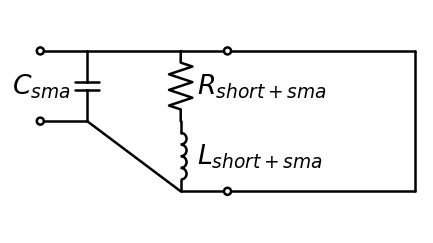

In [617]:
sma_dummy_short_model = sma_dummy_short_model()
sma_dummy_short_schematic()

Open Z11/Z22 Symbolic Model:


     -ⅈ⋅(C_fr + Cₚₚ)     
─────────────────────────
Cₚₚ⋅\omega⋅(2⋅C_fr + Cₚₚ)

Open Z21/Z12 Symbolic Model:


                   -1                    
─────────────────────────────────────────
   2       2 ⎛     2⋅ⅈ            ⅈ     ⎞
Cₚₚ ⋅\omega ⋅⎜- ────────── - ───────────⎟
             ⎝  Cₚₚ⋅\omega   C_fr⋅\omega⎠

Open Z Matrix:


⎡⎡     -ⅈ⋅(C_fr + Cₚₚ)                          -1                    ⎤  ⎡    
⎢⎢─────────────────────────, ─────────────────────────────────────────⎥, ⎢────
⎢⎢Cₚₚ⋅\omega⋅(2⋅C_fr + Cₚₚ)     2       2 ⎛     2⋅ⅈ            ⅈ     ⎞⎥  ⎢   2
⎢⎢                           Cₚₚ ⋅\omega ⋅⎜- ────────── - ───────────⎟⎥  ⎢Cₚₚ 
⎣⎣                                        ⎝  Cₚₚ⋅\omega   C_fr⋅\omega⎠⎦  ⎣    

               -1                           -ⅈ⋅(C_fr + Cₚₚ)     ⎤⎤
─────────────────────────────────────, ─────────────────────────⎥⎥
       2 ⎛     2⋅ⅈ            ⅈ     ⎞  Cₚₚ⋅\omega⋅(2⋅C_fr + Cₚₚ)⎥⎥
⋅\omega ⋅⎜- ────────── - ───────────⎟                           ⎥⎥
         ⎝  Cₚₚ⋅\omega   C_fr⋅\omega⎠                           ⎦⎦

Open Schematic Model:
[[<function <lambda> at 0x000000000C2F8E18>, <function <lambda> at 0x000000000E1BB6A8>], [<function <lambda> at 0x000000000E1BBAE8>, <function <lambda> at 0x000000000E1BBE18>]]


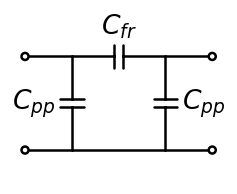

In [757]:
open_Z_matrix, open_Z_fns = open_Z_model()
open_schematic()

Shunt-Short Via Z11 Symbolic Model:


      -ⅈ⋅(ⅈ⋅L⋅\omega + R)      
───────────────────────────────
2⋅C⋅\omega⋅(ⅈ⋅L⋅\omega + R) - ⅈ

Shunt-Short Via Schematic Model:


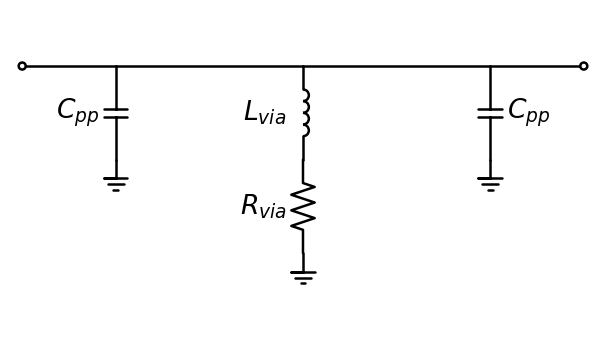

In [619]:
shunt_short_model = shunt_short_model()
shunt_short_schematic()

In [620]:
zero_ohm_series_model = zero_ohm_series_model()

Zero Ohm Series Z11 Symbolic Model:


      ⅈ⋅(-C_pack⋅\omega⋅(ⅈ⋅L_pack⋅\omega + R_pack) - Cₚₚ⋅\omega⋅(ⅈ⋅L_pack⋅\ome
──────────────────────────────────────────────────────────────────────────────
Cₚₚ⋅\omega⋅(2⋅C_pack⋅\omega⋅(ⅈ⋅L_pack⋅\omega + R_pack) + Cₚₚ⋅\omega⋅(ⅈ⋅L_pack⋅

ga + R_pack) + ⅈ)      
───────────────────────
\omega + R_pack) - 2⋅ⅈ)

In [774]:
# types of loss functions (mag, phase, mp_combo)
def optimize_for_Z(Z_matrix_fns, initial_guess, measured_data, debug=False, loss_fn='mag'):
    measured_Z11 = measured_data.z[:,0,0]
    measured_Z21 = measured_data.z[:,0,1]
    measured_omega = measured_data.frequency.w
    
    def objective_fn(guess):
        if debug:
            print("guess: ", guess)
        model_args_packed = [np.tile(x, len(measured_omega)) for x in guess]
        model_Z11 = Z_matrix_fns[0][0](measured_omega, *model_args_packed)
        model_Z21 = Z_matrix_fns[1][0](measured_omega, *model_args_packed)
        
        #### TODO:
        # Refine these functions to work properly for complex numbers (proper complex MSE)
        # Include a multiplication factor to weight errors near 600 Mhz more than near the edges
        Z11_mag_loss = np.subtract(np.log(np.abs(model_Z11)), np.log(np.abs(measured_Z11)))
        Z11_phase_loss = np.subtract(np.log(np.abs(np.angle(model_Z11))), np.log(np.abs(np.angle(measured_Z11))))
        Z21_mag_loss = np.subtract(np.log(np.abs(model_Z21)), np.log(np.abs(measured_Z21)))
        Z21_phase_loss = np.subtract(np.log(np.abs(np.angle(model_Z21))), np.log(np.abs(np.angle(measured_Z21))))

        freq_loss_adjust = [(x - 600e6*2*np.pi)**2 for x in measured_omega]
        loss_vector = 0
        if (loss_fn is 'mag'):
            loss_vector = Z11_mag_loss + Z21_mag_loss
        elif (loss_fn is 'phase'):
            loss_vector = Z11_phase_loss + Z21_phase_loss
        elif (loss_fn is 'mp_combo'):
            loss_vector = Z11_mag_loss + Z21_mag_loss + Z11_phase_loss + Z21_phase_loss
            
        MSE = (1.0 / len(measured_omega)) \
            * np.sum(np.abs(np.multiply(loss_vector, freq_loss_adjust)))

        # Steer the optimizer away from excessively small component values
        if np.any(guess < 1e-17):
            MSE = MSE + MSE*(10**10)
        if debug:
            print("error: %f" % MSE)
        return MSE
    
    model_fit = scipy.optimize.minimize(objective_fn, initial_guess, method='Nelder-Mead', options={'fatol': 1e-12, 'xatol': 1e-12})
    return model_fit

def compare_fit_with_data(z_matrix_fns, model_fit_params, measured_data, title=''):
    measured_Z11 = measured_data.z[:,0,0]
    measured_Z21 = measured_data.z[:,1,0]
    measured_omega = measured_data.frequency.w
    measured_f = np.divide(measured_omega, 2*np.pi)
    
    model_fit_params_packed = [np.tile(x, len(measured_omega)) for x in model_fit_params]
    model_Z11 = z_matrix_fns[0][0](measured_omega, *model_fit_params_packed)
    model_Z21 = z_matrix_fns[1][0](measured_omega, *model_fit_params_packed)
    
    w, h = plt.figaspect(0.5)
    fig = plt.figure(figsize=(w,h))
    
    plt.subplot(2, 2, 1)
    plt.tight_layout()
    plt.plot(measured_f, mag2db(np.abs(model_Z11)))
    plt.plot(measured_f, mag2db(np.abs(measured_Z11)))
    plt.title('$Z_{11}$ Measured vs. Model - ' + title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('$|Z_{11}|$ (dB)')
    plt.legend(['Model', 'Measured'])
    
    plt.subplot(2, 2, 2)
    plt.tight_layout()
    plt.plot(measured_f, rad2deg(np.angle(model_Z11)))
    plt.plot(measured_f, rad2deg(np.angle(measured_Z11)))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('$\measuredangle Z_{11}$ (deg)')
    plt.legend(['Model', 'Measured'])
    
    plt.subplot(2, 2, 3)
    plt.tight_layout()
    plt.plot(measured_f, mag2db(np.abs(model_Z21)))
    plt.plot(measured_f, mag2db(np.abs(measured_Z21)))
    plt.title('$Z_{21}$ Measured vs. Model - ' + title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('$|Z_{21}|$ (dB)')
    plt.legend(['Model', 'Measured'])
    
    plt.subplot(2, 2, 4)
    plt.tight_layout()
    plt.plot(measured_f, rad2deg(np.angle(model_Z21)))
    plt.plot(measured_f, rad2deg(np.angle(measured_Z21)))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('$\measuredangle Z_{21}$ (deg)')
    plt.legend(['Model', 'Measured'])

[  2.71266453e-13   2.05569923e-09   1.83384699e-01]
L = 2.055699 nH | C = 0.271266 pF | R = 0.183385 Ohms
SMA Dummy Short Schematic Model:


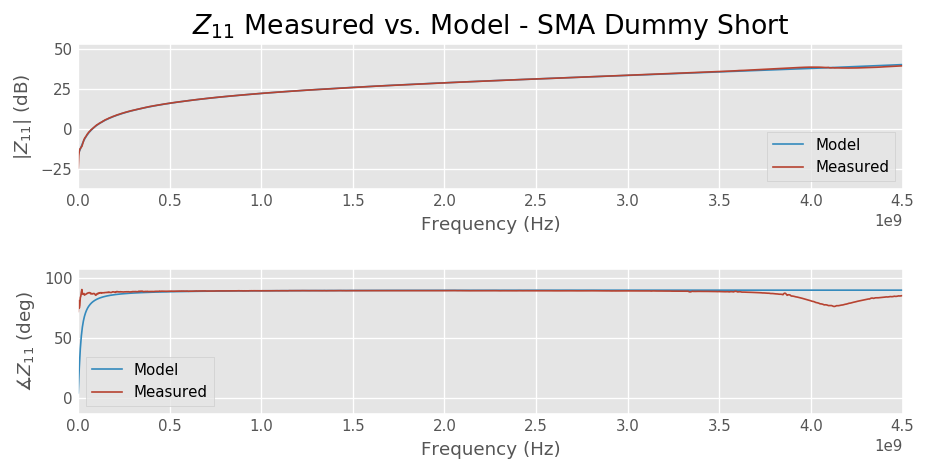

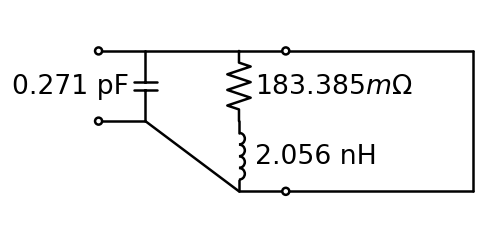

In [691]:
sma_dummy_short_fit = optimize_for_Z11(sma_dummy_short_model, (1e-12, 1e-9, 100e-3), sma_dummy_short_data, loss_fn='mag')
print(sma_dummy_short_fit.x)
compare_fit_with_data(sma_dummy_short_model, sma_dummy_short_fit.x, sma_dummy_short_data, title='SMA Dummy Short')
print("L = %f nH | C = %f pF | R = %f Ohms" %(sma_dummy_short_fit.x[1]/1e-9, sma_dummy_short_fit.x[0]/1e-12, sma_dummy_short_fit.x[2]))
sma_dummy_short_schematic(R=mOhm(sma_dummy_short_fit.x[2]), C=pF(sma_dummy_short_fit.x[0]), L=nH(sma_dummy_short_fit.x[1]))

[  1.95169551e-14   4.45275134e-14]
 final_simplex: (array([[  1.95169551e-14,   4.45275134e-14],
       [  1.95169551e-14,   4.45275134e-14],
       [  1.95169551e-14,   4.45275134e-14]]), array([  3.97360450e+18,   3.97360450e+18,   3.97360450e+18]))
           fun: 3.9736044951704499e+18
       message: 'Optimization terminated successfully.'
          nfev: 240
           nit: 119
        status: 0
       success: True
             x: array([  1.95169551e-14,   4.45275134e-14])


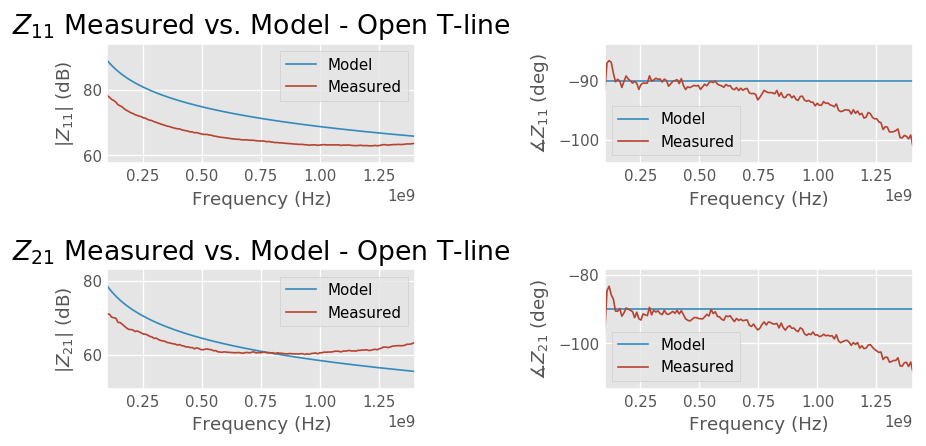

In [775]:
open_fit = optimize_for_Z(open_Z_fns, (10e-15, 10e-12), open_data, loss_fn='mag')
print(open_fit.x)
print(open_fit)
compare_fit_with_data(open_Z_fns, open_fit.x, open_data, title='Open T-line')

guess:  [  1.00000000e-12   1.00000000e-09   1.00000000e-01]
mag_loss: 179.470257, phase_loss: -13.900646
error: 0.871419
guess:  [  1.05000000e-12   1.00000000e-09   1.00000000e-01]
mag_loss: 180.497420, phase_loss: -13.910562
error: 0.876773
guess:  [  1.00000000e-12   1.05000000e-09   1.00000000e-01]
mag_loss: 189.754602, phase_loss: -13.739075
error: 0.926398
guess:  [  1.00000000e-12   1.00000000e-09   1.05000000e-01]
mag_loss: 179.484522, phase_loss: -14.080441
error: 0.870548
guess:  [  1.03333333e-12   9.50000000e-10   1.03333333e-01]
mag_loss: 169.375920, phase_loss: -14.212323
error: 0.816651
guess:  [  1.05000000e-12   9.00000000e-10   1.05000000e-01]
mag_loss: 158.383707, phase_loss: -14.488366
error: 0.757344
guess:  [  9.83333333e-13   9.33333333e-10   1.06666667e-01]
mag_loss: 164.736859, phase_loss: -14.396733
error: 0.791264
guess:  [  1.02222222e-12   8.88888889e-10   1.11111111e-01]
mag_loss: 155.318669, phase_loss: -14.779812
error: 0.739678
guess:  [  1.03333333e-1

mag_loss: 8.948120, phase_loss: -10.709306
error: 0.027807
guess:  [  3.23936481e-12   3.94379391e-10  -4.25236917e-04]
mag_loss: 8.382381, phase_loss: -10.320925
error: 272817251.317477
guess:  [  3.14887041e-12   3.96164061e-10   5.20498719e-03]
mag_loss: 8.594002, phase_loss: -10.824751
error: 0.027808
guess:  [  3.20920001e-12   3.94974281e-10   1.45150445e-03]
mag_loss: 8.453036, phase_loss: -10.489312
error: 0.027433
guess:  [  3.23936481e-12   3.94379391e-10  -4.25236917e-04]
mag_loss: 8.382381, phase_loss: -10.320925
error: 272817251.317477
guess:  [  3.21523426e-12   3.93632434e-10   1.09462560e-03]
mag_loss: 7.764678, phase_loss: -10.457609
error: 0.027379
guess:  [  3.23816053e-12   3.92202023e-10  -3.16922296e-04]
mag_loss: 7.167748, phase_loss: -10.330507
error: 273878869.118007
guess:  [  3.23545378e-12   3.93969150e-10  -2.51118611e-04]
mag_loss: 8.122541, phase_loss: -10.336542
error: 272083030.261488
guess:  [  3.19055670e-12   3.94852461e-10   2.63416756e-03]
mag_loss

error: 0.027219
guess:  [  3.23270876e-12   3.93737429e-10   6.14373224e-07]
mag_loss: 7.971168, phase_loss: -10.359173
error: 0.027219
guess:  [  3.23266053e-12   3.93738713e-10   6.81879911e-07]
mag_loss: 7.971467, phase_loss: -10.359179
error: 0.027219
guess:  [  3.23247738e-12   3.93743596e-10   9.35696474e-07]
mag_loss: 7.972605, phase_loss: -10.359202
error: 0.027219
guess:  [  3.23240380e-12   3.93745560e-10   1.03690250e-06]
mag_loss: 7.973064, phase_loss: -10.359211
error: 0.027219
guess:  [  3.23212517e-12   3.93752991e-10   1.42244720e-06]
mag_loss: 7.974797, phase_loss: -10.359245
error: 0.027218
guess:  [  3.23201302e-12   3.93755983e-10   1.57767422e-06]
mag_loss: 7.975495, phase_loss: -10.359259
error: 0.027218
guess:  [  3.23158893e-12   3.93767293e-10   2.16450947e-06]
mag_loss: 7.978133, phase_loss: -10.359312
error: 0.027218
guess:  [  3.23141890e-12   3.93771825e-10   2.40072887e-06]
mag_loss: 7.979188, phase_loss: -10.359333
error: 0.027218
guess:  [  3.23077396e-1

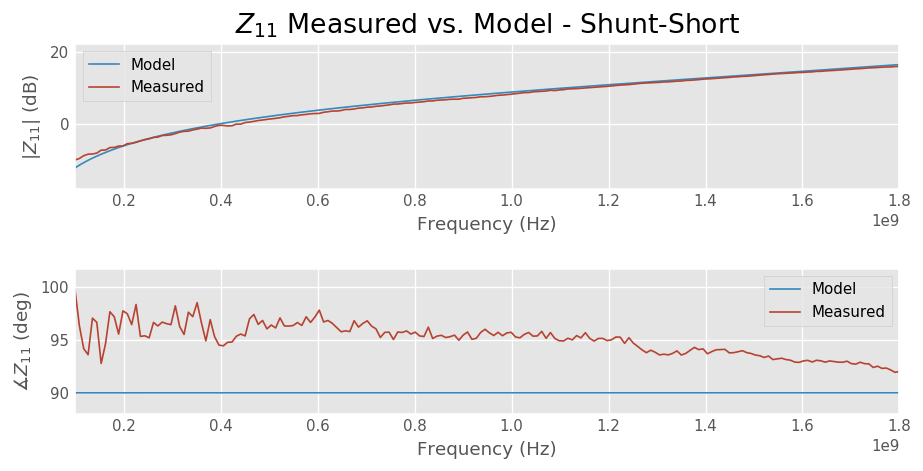

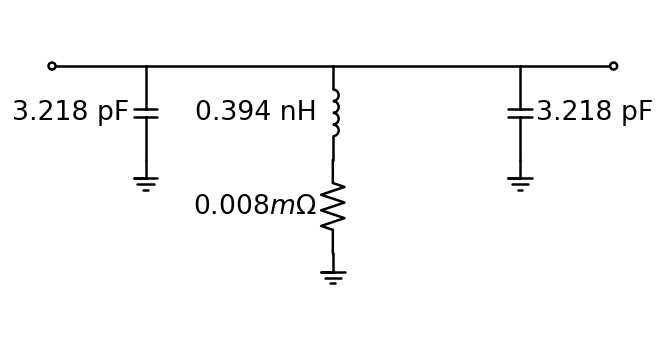

In [699]:
shunt_short_fit = optimize_for_Z11(shunt_short_model, (1e-12, 1e-9, 100e-3), shunt_short_data, debug=True, loss_fn='mp_combo')
print(shunt_short_fit.x)
compare_fit_with_data(shunt_short_model, shunt_short_fit.x, shunt_short_data, title='Shunt-Short')
shunt_short_schematic(C=pF(shunt_short_fit.x[0]), L=nH(shunt_short_fit.x[1]), R=mOhm(shunt_short_fit.x[2]))

[  8.58451957e-14   1.03359634e-15   1.47465513e-01   1.20240381e-15]


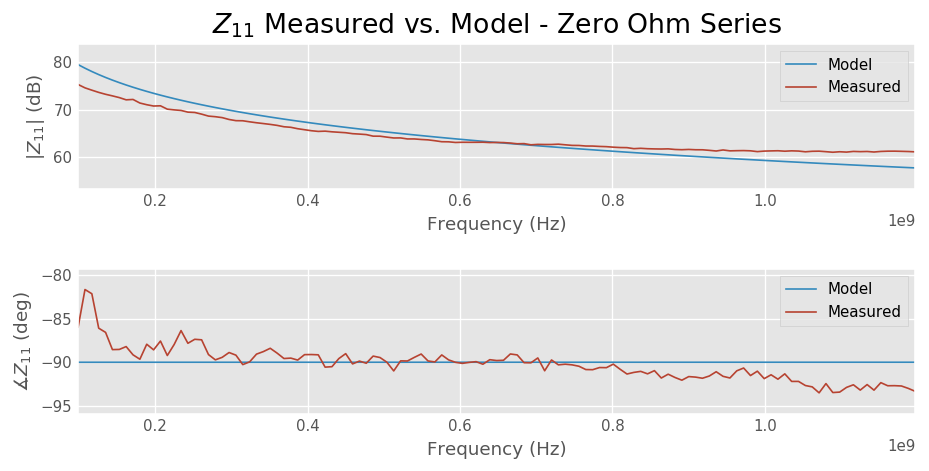

In [702]:
zero_ohm_series_fit = optimize_for_Z11(zero_ohm_series_model, (100e-12, 1e-15, 100e-3, 1e-15), zero_ohm_series_data, loss_fn='mag')
print(zero_ohm_series_fit.x)
compare_fit_with_data(zero_ohm_series_model, zero_ohm_series_fit.x, zero_ohm_series_data, title='Zero Ohm Series')
#shunt_short_schematic(C=pF(shunt_short_fit.x[0]), L=nH(shunt_short_fit.x[1]), R=mOhm(shunt_short_fit.x[2]))